Import dependencies and pollen data

In [10]:
import h5py
import matplotlib.pyplot as plt
import requests
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, losses, optimizers, metrics
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam, SGD

Let's check that the GPU is detected

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We import all the data, already prepared

In [54]:
f = h5py.File('proc_data.h5', 'r')

X_train, Y_train, X_dev, Y_dev, X_test, Y_test = np.array(f['X_train']), np.array(f['Y_train']), np.array(f['X_dev']), np.array(f['Y_dev']), f['X_test'], f['Y_test']

m_train = X_train.shape[0]
window_size = X_train.shape[1]
pred_size = Y_train.shape[1]
anal_size = window_size - pred_size
n = X_train.shape[2]

print('m_train =', m_train)
print('window_size =', window_size)
print(' - anal_size =', anal_size)
print(' - pred_size =', pred_size)
print('n =', n)

print('X_train.shape =', X_train.shape)
print('Y_train.shape =', Y_train.shape)

m_train = 57258
window_size = 15
 - anal_size = 10
 - pred_size = 5
n = 14
X_train.shape = (57258, 15, 14)
Y_train.shape = (57258, 5)


We introduce this methods to split each X_train case into the analysis and prediction part

In [55]:
def get_X_anal(X_in):
    X_anal = X_in[:, :anal_size, :]
    return X_anal

In [56]:
def get_X_pred(X_in):
    X_before_pollen = X_in[:, anal_size:window_size, :2]
    X_after_pollen = X_in[:, anal_size:window_size, 3:]
    
    X_pred = tf.concat([X_before_pollen, X_after_pollen], axis=2)
    
    return X_pred

In [57]:
def get_Y_i(Y_pred, i):
    return Y_pred[:, i, :]

In [108]:
X_in = Input(shape=(window_size, n), name='Input')
print('X_in.shape =',X_in.shape)

X_anal = Lambda(get_X_anal, output_shape=(anal_size, n), name='slice_anal')(X_in)
print('X_anal.shape =',X_anal.shape)

X_pred = Lambda(get_X_pred, output_shape=(pred_size, n), name='slice_pred')(X_in)
print('X_pred.shape =',X_pred.shape)
#analyze the data, we don't need an output, only the hidden state of the LSTM
X_bot, h_bot, c_bot = LSTM(64, return_state=True, return_sequences=True, name='analysis_bot')(X_anal)
print('X_bot.shape =', X_bot.shape)
_, h_top, c_top = LSTM(64, return_state=True, name='analysis_top')(X_bot)


bot_state = [h_bot, c_bot]
top_state = [h_top, c_top]
Y_bot = LSTM(64, return_sequences=True, name='prediction_bot')(X_pred, initial_state=bot_state)
print('Y_bot.shape =', Y_bot.shape)
Y_pred = LSTM(64, return_sequences=True, name='prediction_top')(Y_bot, initial_state=top_state)
print('Y_pred.shape =',Y_pred.shape)

Y_list = []
for i in range(pred_size):
    slicer = Lambda(get_Y_i, arguments={'i': i}, name='slicer-{}'.format(i))
    densor = Dense(units=1, name='densor-{}'.format(i))
    Y_list.append(densor(slicer(Y_pred)))
print('Y_list[0].shape =',Y_list[0].shape)

Y = Concatenate(axis=1)(Y_list)
print('Y.shape =',Y.shape)

model = Model(inputs=X_in, outputs=Y)

X_in.shape = (None, 15, 14)
X_anal.shape = (None, 10, 14)
X_pred.shape = (None, 5, 13)
X_bot.shape = (None, 10, 64)
Y_bot.shape = (None, 5, 64)
Y_pred.shape = (None, 5, 64)
Y_list[0].shape = (None, 1)
Y.shape = (None, 5)


In [109]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 15, 14)]     0                                            
__________________________________________________________________________________________________
slice_anal (Lambda)             (None, 10, 14)       0           Input[0][0]                      
__________________________________________________________________________________________________
slice_pred (Lambda)             (None, 5, 13)        0           Input[0][0]                      
__________________________________________________________________________________________________
analysis_bot (LSTM)             [(None, 10, 64), (No 20224       slice_anal[0][0]                 
___________________________________________________________________________________________

In [113]:
opt = Adam(learning_rate=0.0005, beta_1 = 0.9, beta_2 = 0.99, epsilon=1e-7, clipnorm=1)

model.compile(loss='mse', optimizer=opt, metrics=['mae'])

In [114]:
fitting = model.fit(X_train, Y_train, batch_size=128, epochs = 20, validation_data=(X_dev, Y_dev), shuffle=True)

Epoch 1/20
448/448 [==============================] - 9s 20ms/step - loss: 1.3795 - mae: 0.9144 - val_loss: 1.3957 - val_mae: 0.9236
Epoch 2/20
448/448 [==============================] - 8s 18ms/step - loss: 1.3673 - mae: 0.9087 - val_loss: 1.3656 - val_mae: 0.9127
Epoch 3/20
448/448 [==============================] - 9s 19ms/step - loss: 1.3648 - mae: 0.9080 - val_loss: 1.3526 - val_mae: 0.9065
Epoch 4/20
448/448 [==============================] - 8s 18ms/step - loss: 1.3635 - mae: 0.9075 - val_loss: 1.3826 - val_mae: 0.9183
Epoch 5/20
448/448 [==============================] - 8s 18ms/step - loss: 1.3656 - mae: 0.9083 - val_loss: 1.4038 - val_mae: 0.9232
Epoch 6/20
448/448 [==============================] - 8s 18ms/step - loss: 1.3697 - mae: 0.9093 - val_loss: 1.3793 - val_mae: 0.9161
Epoch 7/20
448/448 [==============================] - 8s 18ms/step - loss: 1.3615 - mae: 0.9068 - val_loss: 1.4095 - val_mae: 0.9260
Epoch 8/20
448/448 [==============================] - 8s 18ms/step - 

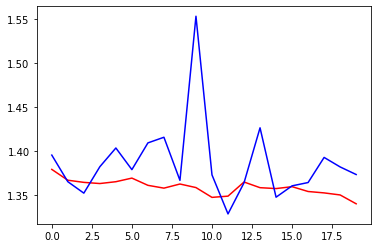

In [115]:
plt.plot(np.array(fitting.history['loss']), color='r')
plt.plot(np.array(fitting.history['val_loss']), color='b')
plt.show()

- v1.0 val_loss = 3.175 after 400 epochs
- v1.1 val_loss = 1.797 after 400 epochs
    - Added precipitation data
- v1.2 val_loss = 0.716 after 400 epochs
    - Added a log kernel to pollen data
    
- v2.0 val_loss = 1130 after 110 epochs
    - Trained with all the data
- v2.1 val_loss = 0.57 after 100 epochs
    - fixed normalization lol
- v3.0 val_loss = 1.51 after 100 epochs
    - Added multi-day forecasting

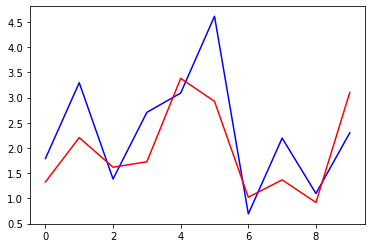

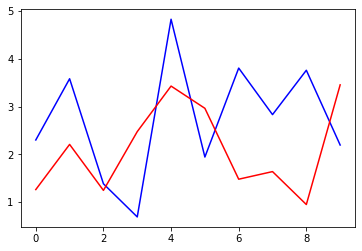

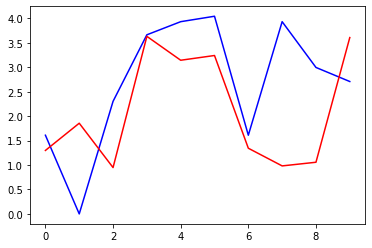

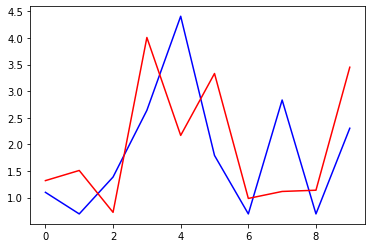

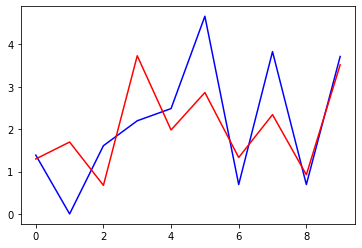

In [116]:
parameters = f['parameters']
pollen_mean = parameters[0, 2]
pollen_std = parameters[1, 2]

start_pred = 140
end_pred = 150

Y_true = Y_dev[start_pred:end_pred]
Y_pred = model(X_dev)[start_pred:end_pred]

for i in range(pred_size):
    plt.plot(Y_true[:, i], color='b')
    plt.plot(Y_pred[:, i], color='r')

    plt.show()

Here we plot the data directly as it is, with the log kernel, and in the next cell reverted back to the original values. I pass it through this log kernel because I suspect that it is what I will use when I classify the predictions into a few classes or 'levels' of pollen in air. This is because, a jump in pollen levels of a fixed amount is much more noticeable if it comes from a low value(where the user might jump from no symptoms to light symptoms) that in a already high value where the user will be fucked up either way.

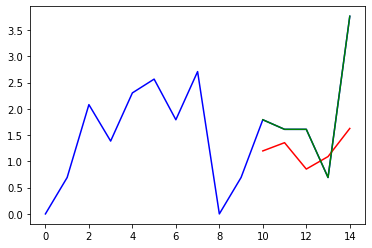

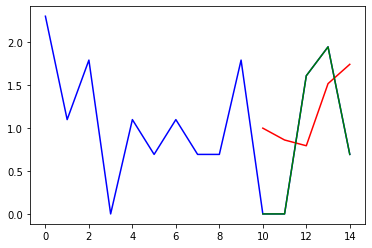

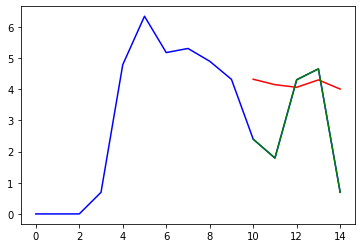

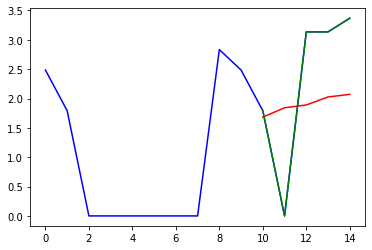

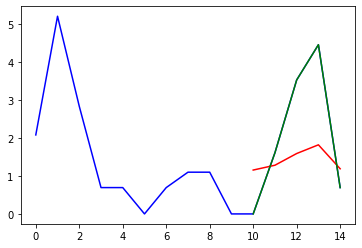

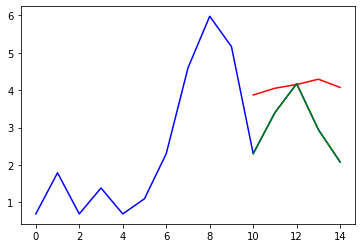

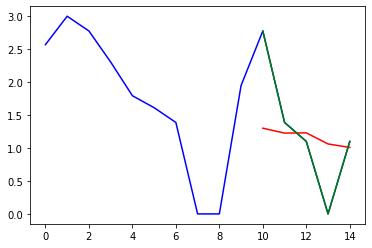

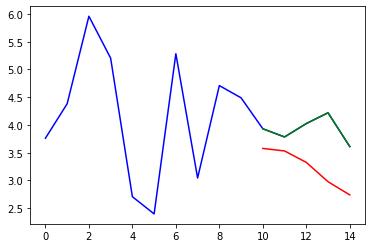

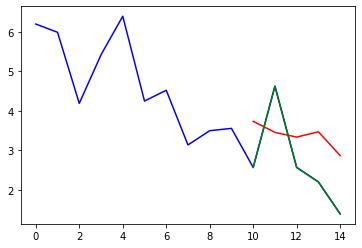

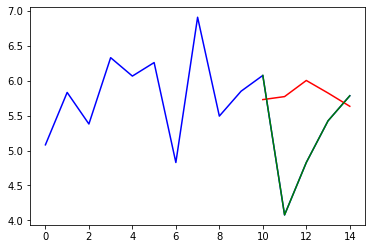

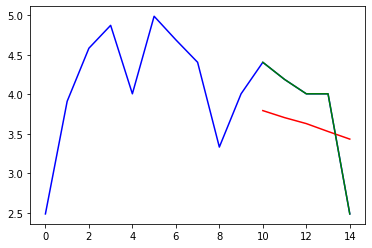

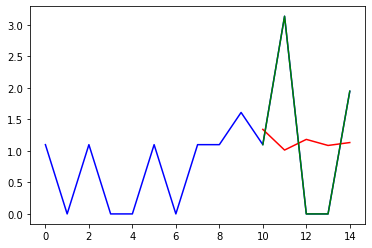

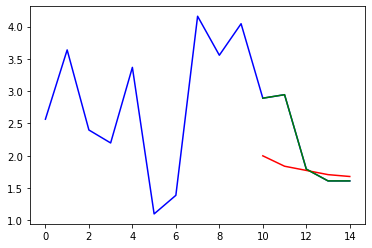

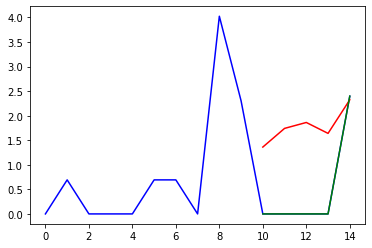

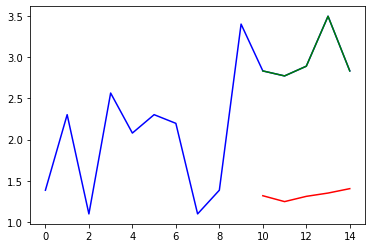

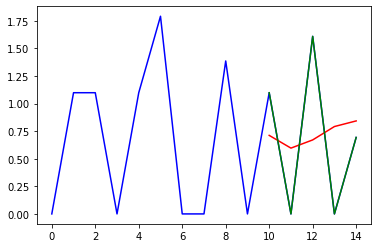

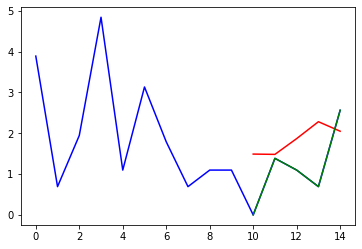

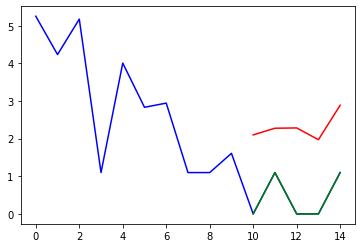

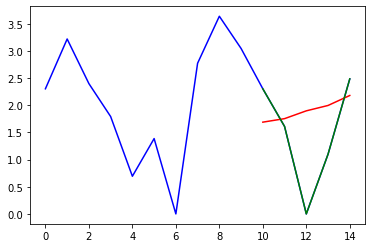

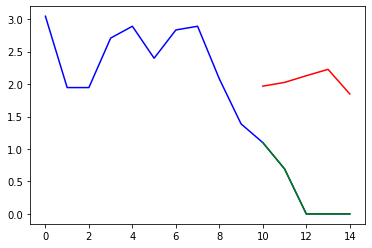

In [118]:
start_windows = 0
end_windows = 20

X_pred = X_dev[start_windows:end_windows]
Y_pred = model(X_pred)
Y_true = Y_dev[start_windows:end_windows]

for i in range(end_windows - start_windows):
    plt.plot(range(window_size), X_pred[i, :, 2], color='b')
    plt.plot(range(anal_size, window_size), Y_pred[i], color='r')
    plt.plot(range(anal_size, window_size), Y_true[i], color='g')
    plt.show()